In [13]:
import pandas as pd
import itertools as itt
import ppinetsim
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
import networkx as nx
import seaborn as sns
from os.path import join

---
# Sanity check

In [3]:
# FPR = FNR = 0, AP-MS testing.
parameters = ppinetsim.Parameters('parameter_settings/params_AP-MS_200.json')

In [5]:
node_degrees_simulated_er, _, node_degrees_er, _ = ppinetsim.run_simulation(parameters, verbose=True)

In [21]:
parameters.generator = 'barabasi-albert'

In [23]:
node_degrees_simulated_ba, _, node_degrees_ba, _ = ppinetsim.run_simulation(parameters, verbose=True)

In [16]:
def _construct_observed_network(parameters):
    edge_list = []
    for sampled_study in parameters.sampled_studies:
        filename = join('ppinetsim', 'data', parameters.test_method, f'{sampled_study}.csv')
        adj_sampled_study = pd.read_csv(filename, index_col=0)
    for edge in itt.product(adj_sampled_study.index, adj_sampled_study.columns):
        if adj_sampled_study.loc[edge]:
            edge_list.append(edge)
    observed_network = nx.Graph()
    observed_network.add_edges_from(edge_list)
    return nx.to_numpy_array(observed_network, dtype=bool)

In [17]:
adj_observed = _construct_observed_network(parameters)
node_degrees_observed = ppinetsim.node_degrees(adj_observed)

In [24]:
distr_observed = ppinetsim.degrees_to_distribution(node_degrees_observed)
distr_simulated_er = ppinetsim.degrees_to_distribution(node_degrees_simulated_er)
distr_simulated_ba = ppinetsim.degrees_to_distribution(node_degrees_simulated_ba)
distr_er = ppinetsim.degrees_to_distribution(node_degrees_er)
distr_ba = ppinetsim.degrees_to_distribution(node_degrees_ba)

Text(0, 0.5, 'Fraction')

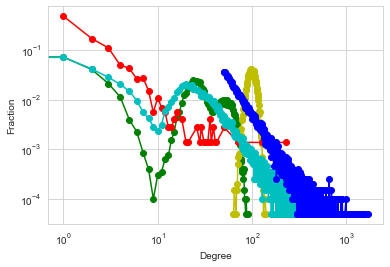

In [27]:
plt.loglog(distr_simulated_er[0,],distr_simulated_er[1,],'go-') # Simulated from ER graph (green)
plt.loglog(distr_er[0,],distr_er[1,],'yo-') # Ground truth ER graph (yellow)
plt.loglog(distr_simulated_ba[0,],distr_simulated_ba[1,],'co-') # Simulated from BA graph (cyan)
plt.loglog(distr_ba[0,],distr_ba[1,],'bo-') # Ground truth BA graph (blue)
plt.loglog(distr_observed[0,],distr_observed[1,],'ro-') # Aggregated PPI network from 91 AP-MS studies with >= 200 PPIs (red)
plt.xlabel('Degree')
plt.ylabel('Fraction')

- **Visual impression:** Using BA as ground (cyan) truth yields distribution that is closer to observed network (red) than using ER as ground truth (green).

In [30]:
wasserstein_distance(distr_simulated_ba[0,], distr_observed[0,], distr_simulated_ba[1,], distr_observed[1,])

24.557512087911338

In [31]:
wasserstein_distance(distr_simulated_er[0,], distr_observed[0,], distr_simulated_er[1,], distr_observed[1,])

19.216220879120883

**But:** The EMD tells a different story (distance for ER is smaller than distance for BA).

**--> Why?**

In [43]:
# Number of edges in observed PPI network
node_degrees_observed.sum() / 2

1606.0

In [49]:
# Numbers of nodes in ovserved PPI network:
len(node_degrees_observed)

728

In [48]:
# Numbers of edges in network simulated form ER graph.
node_degrees_simulated_er.sum() / 2

223292.0

In [50]:
# Numbers of nodes in network simulated form ER graph.
len(node_degrees_simulated_er)

20000

In [47]:
# Numbers of edges in network simulated form BA graph.
node_degrees_simulated_ba.sum() / 2

285334.0

In [51]:
# Numbers of nodes in network simulated form BA graph.
len(node_degrees_simulated_ba)

20000

- **Observation**: With our parameter settings, we have much more edges in simulated networks than in the observed network obtained by merging the 91 AP-MS studies with >= 200 PPIs.
- So we are comparing networks that live on completely different scales.
- **Consequence:** Need to either reduce numbers of nodes and edges in simulated networks or aggregate much more studies to obtain significantly larger observed networks.

In [52]:
# Fraction of discovered
node_degrees_simulated_er.sum() / node_degrees_er.sum()

0.223292

In [46]:
# Fraction of discovered
node_degrees_simulated_ba.sum() / node_degrees_ba.sum()

0.28603507196137734

- In our simulations, we recover around 25% of the edges in the ground truth edges (at least with the parameter settings we have used for the sanity check).
- **One option that might work:** Set numbers of nodes in ground truth to number of nodes in aggregated observed network and number of edges in ground truth to 4 times the number of edges in observed network.
- **What do you think?**
- I'd like to have your feedback before moving on, because this change would require some additional implementation work.

---
# Other stuff

In [15]:
filename = 'ppinetsim/data/AP-MS/1328865.csv'
adj_sampled_study = pd.read_csv(filename, index_col=0)

In [41]:
likelihood_at_k['k'] = likelihood_at_k.index

In [42]:
data = likelihood_at_k.melt(value_vars=['erdos-renyi', 'barabasi-albert'], id_vars=['k'],
                     var_name='generator', value_name='likelihood')

In [26]:
data

,k,generator,likelihood
0,1,erdos-renyi,1.000000
1,2,erdos-renyi,0.500000
2,3,erdos-renyi,0.666667
3,4,erdos-renyi,0.750000
4,5,erdos-renyi,0.800000
5,6,erdos-renyi,0.666667
6,7,erdos-renyi,0.571429
7,8,erdos-renyi,0.500000
8,9,erdos-renyi,0.444444
9,10,erdos-renyi,0.500000


In [18]:
edge_list = []
for edge in itt.product(adj_sampled_study.index, adj_sampled_study.columns):
    if adj_sampled_study.loc[edge]:
        edge_list.append(edge)

In [21]:
observed_network = nx.Graph()
observed_network.add_edges_from(edge_list)

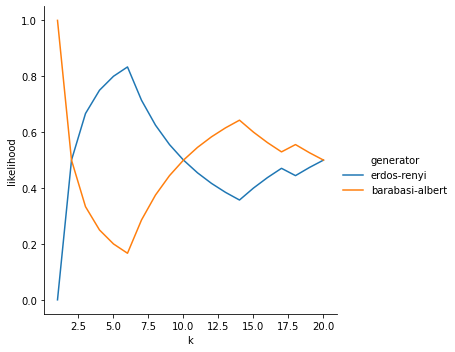

In [43]:
fig = sns.relplot(data=data, x='k', y='likelihood', hue='generator', kind='line')

In [37]:
fig.savefig('bayesian_inference.pdf')